## Intro

Unlike most tutorials, instead of using plain Python and NumPy, we focus on PyTorch. That way you can use the same tool for training yourself and training networks!

Of course, both Python and NumPy are indisponsable. 



In [44]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from livelossplot import PlotLosses

In [3]:
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

In [5]:
X.shape

(100, 2)

In [7]:
X.dtype

dtype('float64')

In [6]:
y.shape

(100,)

In [8]:
y.dtype

dtype('int64')

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

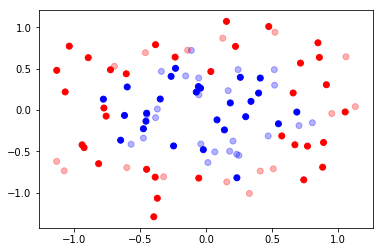

In [42]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3)

In [17]:
dataloaders = {
    'train':
    DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()),
               batch_size=64,
               shuffle=True, num_workers=4),
    'validation': 
    DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()),
               batch_size=64,
               shuffle=False, num_workers=4)
}

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels.data).sum().item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc
        
        liveloss.update(logs)
        liveloss.draw()
    return model

In [47]:
`

In [24]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 2)
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [58]:
def predict_pytorch(model, x_numpy):
    x = torch.from_numpy(x_numpy).float()
    return model(x).softmax(dim=1).detach().numpy()

In [61]:
def draw_prediction_map(model, with_points=True):
    # class 1 is true
    Z = predict_pytorch(model, np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    if with_points:
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3)

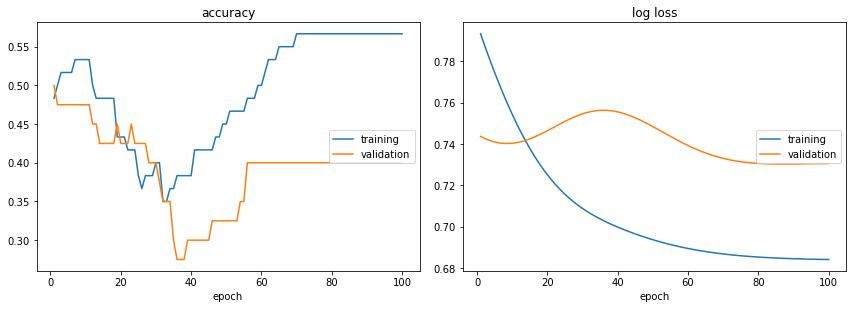

accuracy:
training   (min:    0.350, max:    0.567, cur:    0.567)
validation (min:    0.275, max:    0.500, cur:    0.400)

log loss:
training   (min:    0.684, max:    0.793, cur:    0.684)
validation (min:    0.730, max:    0.756, cur:    0.731)


In [63]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

model_trained = train_model(model, criterion, optimizer, num_epochs=100)

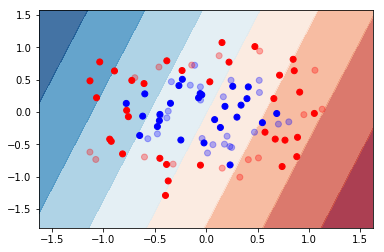

In [64]:
draw_prediction_map(model)

In [69]:
class Hidden(nn.Module):
    def __init__(self, hidden_size=3, activation='relu'):
        super().__init__()
        
        act = {
            'relu': nn.ReLU(inplace=True),
            'sigmoid': nn.Sigmoid()
        }[activation]

        self.fc = nn.Sequential(
            nn.Linear(2, hidden_size),
            act,
            nn.Linear(hidden_size, 2)
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x

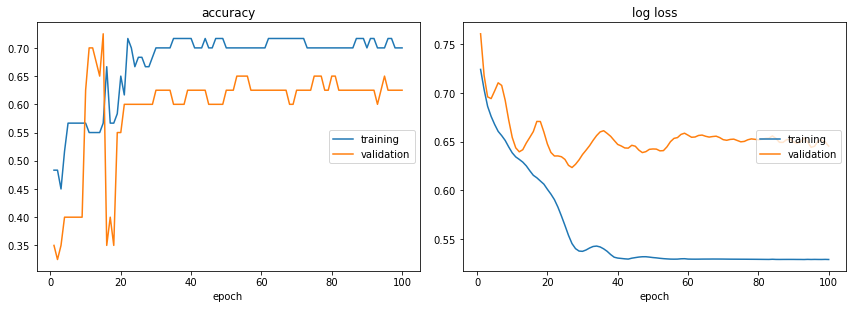

accuracy:
training   (min:    0.450, max:    0.717, cur:    0.700)
validation (min:    0.325, max:    0.725, cur:    0.625)

log loss:
training   (min:    0.529, max:    0.724, cur:    0.529)
validation (min:    0.623, max:    0.761, cur:    0.645)


In [34]:
model = Hidden(3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

model_trained = train_model(model, criterion, optimizer, num_epochs=100)

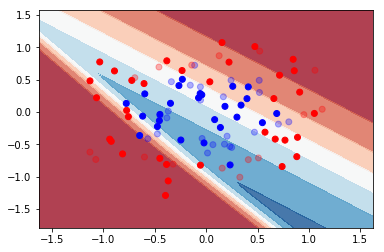

In [62]:
draw_prediction_map(model)

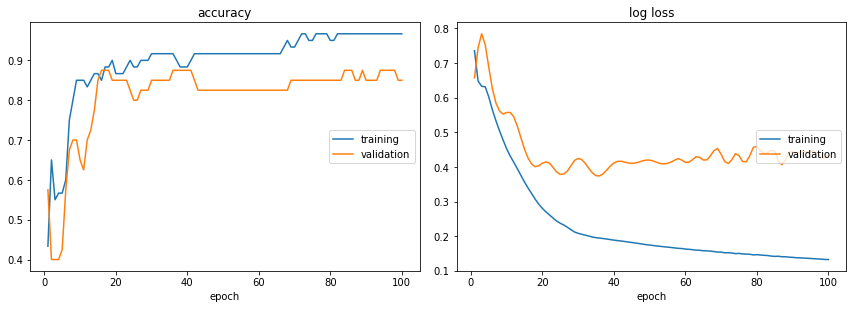

accuracy:
training   (min:    0.433, max:    0.967, cur:    0.967)
validation (min:    0.400, max:    0.875, cur:    0.850)

log loss:
training   (min:    0.132, max:    0.736, cur:    0.132)
validation (min:    0.374, max:    0.785, cur:    0.435)


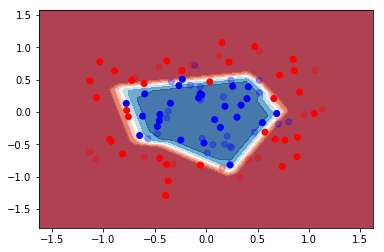

In [65]:
model = Hidden(6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

model_trained = train_model(model, criterion, optimizer, num_epochs=100)

draw_prediction_map(model)

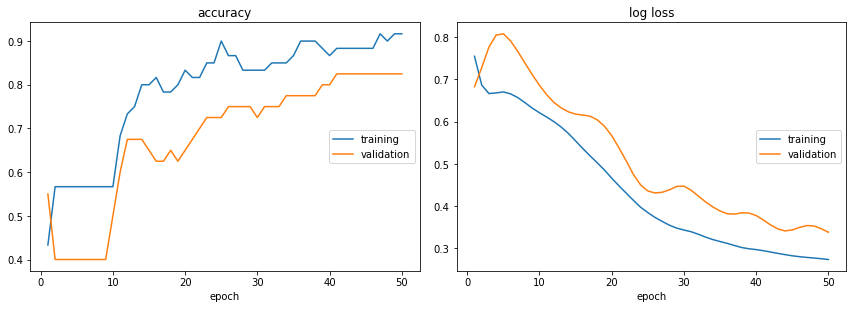

accuracy:
training   (min:    0.433, max:    0.917, cur:    0.917)
validation (min:    0.400, max:    0.825, cur:    0.825)

log loss:
training   (min:    0.274, max:    0.754, cur:    0.274)
validation (min:    0.338, max:    0.808, cur:    0.338)


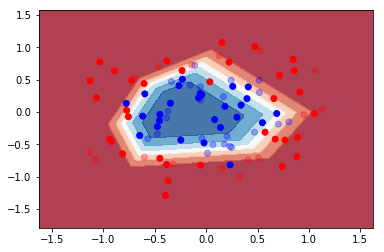

In [70]:
model = Hidden(3, activation='relu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

model_trained = train_model(model, criterion, optimizer, num_epochs=50)

draw_prediction_map(model)

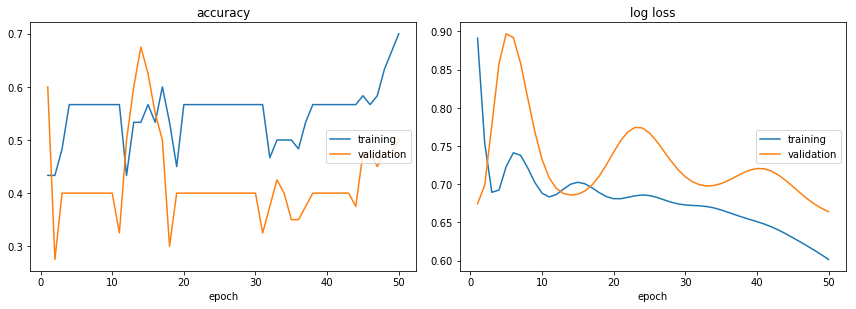

accuracy:
training   (min:    0.433, max:    0.700, cur:    0.700)
validation (min:    0.275, max:    0.675, cur:    0.500)

log loss:
training   (min:    0.601, max:    0.891, cur:    0.601)
validation (min:    0.664, max:    0.897, cur:    0.664)


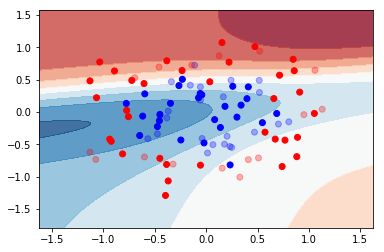

In [71]:
model = Hidden(3, activation='sigmoid')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

model_trained = train_model(model, criterion, optimizer, num_epochs=50)

draw_prediction_map(model)

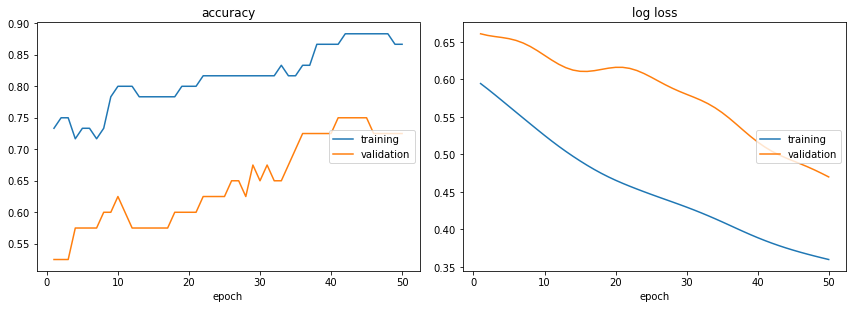

accuracy:
training   (min:    0.717, max:    0.883, cur:    0.867)
validation (min:    0.525, max:    0.750, cur:    0.725)

log loss:
training   (min:    0.360, max:    0.595, cur:    0.360)
validation (min:    0.470, max:    0.661, cur:    0.470)


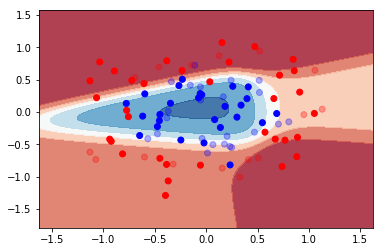

In [72]:
model_trained = train_model(model, criterion, optimizer, num_epochs=50)

draw_prediction_map(model)

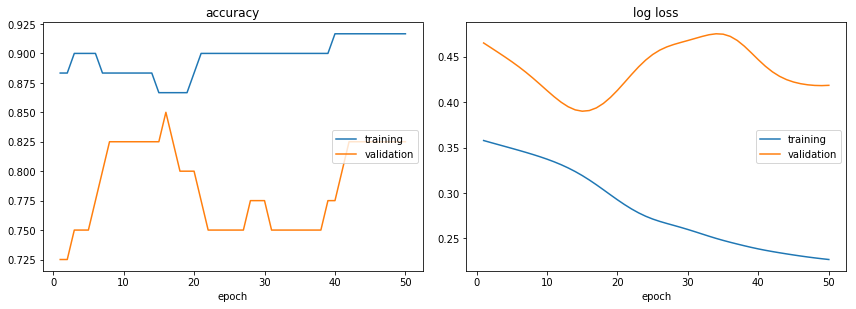

accuracy:
training   (min:    0.867, max:    0.917, cur:    0.917)
validation (min:    0.725, max:    0.850, cur:    0.825)

log loss:
training   (min:    0.227, max:    0.358, cur:    0.227)
validation (min:    0.390, max:    0.475, cur:    0.418)


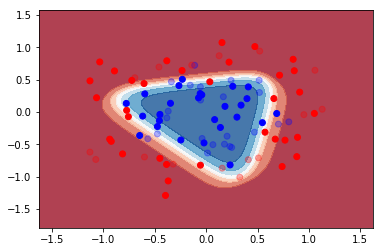

In [73]:
model_trained = train_model(model, criterion, optimizer, num_epochs=50)

draw_prediction_map(model)

CPU times: user 98.6 ms, sys: 4.24 ms, total: 103 ms
Wall time: 89.9 ms


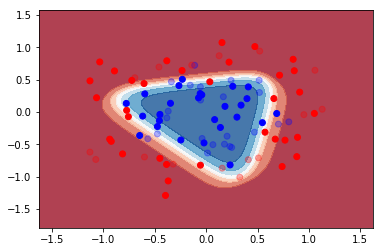

In [76]:
%%time
draw_prediction_map(model)

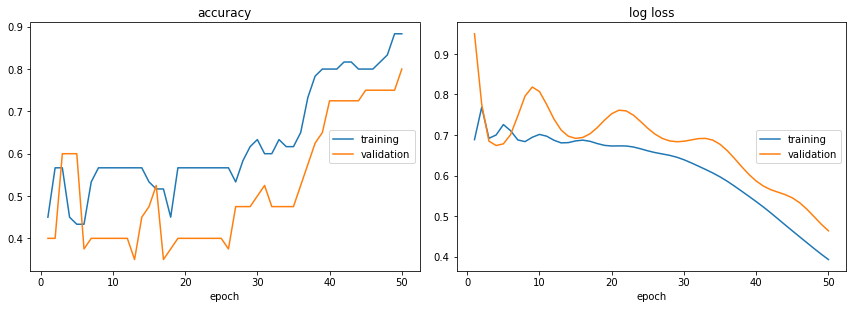

accuracy:
training   (min:    0.433, max:    0.883, cur:    0.883)
validation (min:    0.350, max:    0.800, cur:    0.800)

log loss:
training   (min:    0.393, max:    0.769, cur:    0.393)
validation (min:    0.464, max:    0.950, cur:    0.464)


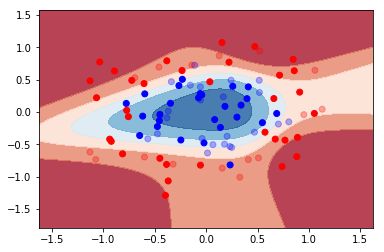

In [77]:
model = Hidden(8, activation='sigmoid')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)

model_trained = train_model(model, criterion, optimizer, num_epochs=50)

draw_prediction_map(model)

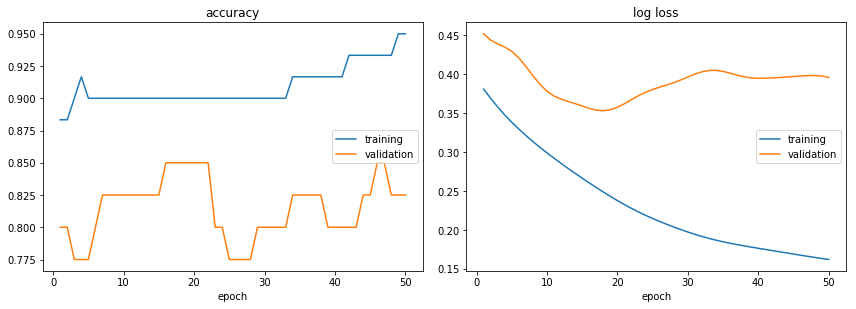

accuracy:
training   (min:    0.883, max:    0.950, cur:    0.950)
validation (min:    0.775, max:    0.850, cur:    0.825)

log loss:
training   (min:    0.162, max:    0.381, cur:    0.162)
validation (min:    0.353, max:    0.452, cur:    0.396)


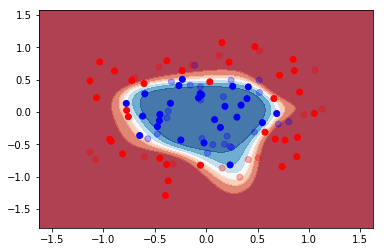

In [78]:
model_trained = train_model(model, criterion, optimizer, num_epochs=50)

draw_prediction_map(model)